### Importing Libraries

In [ ]:
import cv2
import numpy as np
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort
from IPython.display import display, clear_output, HTML
import matplotlib.pyplot as plt
plt.ion()

### Loading model

In [ ]:
model = YOLO('best.pt')

### Player Detection and Tracking

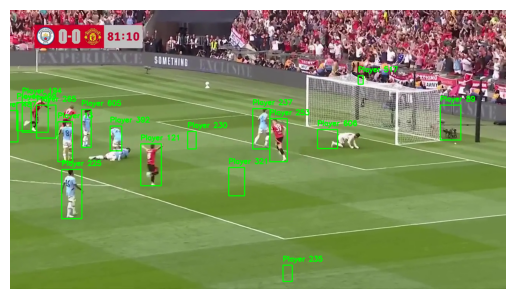


0: 384x640 (no detections), 828.6ms
Speed: 1.8ms preprocess, 828.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 player, 764.3ms
Speed: 2.1ms preprocess, 764.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 player, 766.1ms
Speed: 1.5ms preprocess, 766.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 player, 812.7ms
Speed: 1.9ms preprocess, 812.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


In [7]:
# Initialize Deep SORT tracker
tracker = DeepSort(
    max_age=200,
    n_init=5,
    nms_max_overlap=0.1,
    max_iou_distance=0.3,
    max_cosine_distance=0.2,
    nn_budget=300,
    embedder='mobilenet',
    half=True,
    bgr=True,
    embedder_gpu=True
)

# Load video
cap = cv2.VideoCapture('15sec_input_720p.mp4')
fps = int(cap.get(cv2.CAP_PROP_FPS))
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Output video writer
output = cv2.VideoWriter('output.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))

track_class_map = {}

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Run model
    results = model(frame)[0]

    detections = []

    for det in results.boxes.data.tolist():
        x1, y1, x2, y2, conf, cls_id = det
        cls_id = int(cls_id)

        if conf < 0.6 or (x2 - x1 < 10 or y2 - y1 < 10) or results.names[cls_id] != 'player':
            continue

        bbox = [int(x1), int(y1), int(x2 - x1), int(y2 - y1)]
        detections.append((bbox, conf, 'player'))

    if not detections:
        continue

    # Update tracker
    tracks = tracker.update_tracks(detections, frame=frame)

    for track in tracks:
        if not track.is_confirmed():
            continue

        track_id = track.track_id

        if track_id not in track_class_map:
            track_class_map[track_id] = 'player'

        if track_class_map[track_id] != 'player':
            continue

        x1, y1, x2, y2 = map(int, track.to_ltrb())
        color = (0, 255, 0)
        cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
        cv2.putText(frame, f'Player {track_id}', (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    # Write to output
    output.write(frame)

    # Show in notebook
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.imshow(frame_rgb)
    plt.axis('off')
    clear_output(wait=True)
    display(plt.gcf())

# Cleanup
cap.release()
output.release()
plt.close()